In [25]:
from sklearn import ensemble
import csv
import pandas as pd
import numpy as np
import math
import re
import os
import string
from sklearn import metrics
import xgboost as xgbf
import statsmodels.api as sm
import numpy as np
import got3
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from gensim.models import AuthorTopicModel
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression, Lasso, LassoCV           
from sklearn.model_selection import StratifiedShuffleSplit    
import statsmodels.formula.api as smf
from sklearn.cross_validation import cross_val_score
import time
from importlib import reload
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,  fbeta_score, roc_auc_score, matthews_corrcoef
import pickle
import nltk
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.model_selection
#Find number of clusters
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score


import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
import copy

%matplotlib inline
pd.options.display.max_colwidth = 100

X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
    
# def somefunction():
# clf = ensemble.RandomForestClassifier()
# param_grid = {'n_estimators': [10,20]}
# grid_s= GridSearchCV(clf, param_grid=param_grid,n_jobs=-1,verbose=1)
# grid_s.fit(X, y)
#     return grid_s

# if __name__ == '__main__':
#     somefunction()

#GridSearchCV(clf, param_grid=param_grid,n_jobs=-1,verbose=1)

from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=8).fit(X)
kmeans.labels_
#array([0, 0, 0, 1, 1, 1], dtype=int32)
kmeans.predict([[0, 0], [4, 4]])
#array([0, 1], dtype=int32)
kmeans.cluster_centers_
#array([[ 1.,  2.],
#       [ 4.,  2.]])

array([[3.        , 3.33333333],
       [2.        , 0.66666667]])

### Loading the data

Grabbing data from MongoDB where User tweets are held

In [4]:
import pymongo
client = pymongo.MongoClient("mongodb://louis: @ec2-54-148-44-124.us-west-2.compute.amazonaws.com/twitter") # defaults to port 27017
db = client.twitter
collection = db ['twitter_users']
#df=pd.DataFrame(list(collection.find()))

In [5]:
df_u_tweets = pd.DataFrame(list(collection.find()))

NameError: name 'pd' is not defined

In [505]:
df_u_tweets.shape


(36775, 11)

In [506]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [911]:
import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string
import nltk
from nltk.stem.lancaster import LancasterStemmer

punctuation = list(string.punctuation)

stopwords_lst = stopwords.words('english') + punctuation + \
                ['rt', 'via', 'RT', '…', '–' , '‘', '’', '“', '”'] + \
                [str(x) for x in range(0,10)] + \
                ['added', 'favorited', 'liked', 'video', 'playlist']
    
                    
#english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    
    
def process_tweet_text(tweet, clean = True):

    if clean:
        tweet = p.clean(tweet)
    
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
   
    tweet = tweet.lower()
    
    named_things = ['reilly bodycomb', 
                    'top rock',
                    'leg lock',
                    'leg attack',
                    'knee bar', 
                    'ankle lock',
                    'achilles lock',
                    'heel hook', 
                    'toe hold', 
                    'arm bar', 
                    'rear naked choke', 
                    'full guard', 
                    'half guard', 
                    'no gi'
                    'no kurtka', 
                    'leg reap',
                    'back step'
                    'guard pass',
                    'no gi', 
                    'combat sambo',
                    'sport sambo',
                    'sambo wrestling,'
                    'submission only',
                    'submission grappling',
                    'brazilian j',
                    'jiu jit',
                    'ju jit',
                    'mixed martial arts',
                    'mixed marital arts']

    for i in named_things:
        condensed_name = i.replace(' ','')
        tweet = tweet.replace(i, condensed_name)
        tweet = tweet.replace(condensed_name+'s', condensed_name)

    named_variations = {'top rock 2: turbo': 'toprock', 
                        'top rock 2': 'toprock', 
                        'top rock turbo': 'toprock',
                        'achilleslock': 'anklelock',
                        'leglock': 'leglock',
                        'leglocking' : 'leglock',
                        'legattack ': 'leglock',
                        'jujitsu': 'jiujitsu',
                        'jujitu': 'bjj',
                        'jiujitu': 'bjj',
                        'brazilian jiu-jitsu': 'bjj',
                        'brazilianjiujitsu': 'bjj',
                        'jiujitsu': 'bjj',
                        'sportsambo': 'sambo',
                        'sambowrestling': 'sambo',
                        'reillybodycomb': 'reilly',
                        'rdojo': 'reilly',
                        'r-dojo': 'reilly',
                        'mixedmartialarts': 'mma',
                        'mixedmaritalarts': 'mma'}

    for i, j in named_variations.items():
        tweet = tweet.replace(i, j)
        
    tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
    
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    
    #remove stop words
    tokens = [i.lower() for i in tokens if i not in stopwords_lst]
    
    #english only
    tokens = [i.lower() for i in tokens if isEnglish(i)]
    
    #words that contain "bjj" are about bjj 
    tokens = ['bjj' if 'bjj' in i  else i for i in tokens]

    lmtzr = WordNetLemmatizer()
    stmmr = LancasterStemmer()
    
    #stem and lemmatize words. Round2 removed stemming: stmmr.stem(
    tokens = [lmtzr.lemmatize(w) if w != 'reilly' else 'reilly' for w in tokens]
    
    #return ' '.join(tokens)
    return tokens



In [508]:
df_u_tweets['text'] = df_u_tweets['text'].str.strip()

In [509]:
df_u_tweets['processed'] = df_u_tweets['text'].apply(process_tweet_text)

In [510]:
df_u_tweets['processed_hashtags'] = df_u_tweets['hashtags'].apply(lambda x: process_tweet_text(x, clean=False))

In [511]:
# Remove infrequent words 
twtok = TweetTokenizer(strip_handles=True, reduce_len=True)    
all_tokens = pd.DataFrame(np.concatenate(df_u_tweets['processed']), columns = ['tokens'])
token_cts = all_tokens['tokens'].value_counts(ascending = True) 
#token_cts[token_cts  == 7]

stopwords_lst = stopwords_lst + token_cts[token_cts  <= 8].index.tolist()


In [512]:
df_u_tweets['processed'] = df_u_tweets['processed'].apply(lambda x: process_tweet_text(' '.join(x)))

In [513]:
#df_u_tweets.to_pickle('at_df_u_tweets.pkl')

In [8]:
df_u_tweets = pd.read_pickle('at_df_u_tweets.pkl')

In [9]:
df_u_tweets.query('text ==""').index



Int64Index([    1,     4,    11,   304,   316,   329,   330,   353,   360,
              361,   365,   366,   367,   368,   377,   378,   379,   381,
              382,   392,   393,   395,   397,   476,   477,  3210,  4220,
             4280,  6431,  8328,  8344,  8362,  8367,  8375,  8391,  8410,
            11247, 11264, 12652, 13737, 14002, 14177, 14180, 14188, 14203,
            15955, 16239, 16241, 16242, 16253, 16258, 16259, 16278, 16306,
            18385, 18403, 20817, 20822, 21885, 21917, 21944, 23637, 24062,
            31586, 32823, 34963, 35413],
           dtype='int64')

In [515]:
df_u_tweets.shape

(36775, 13)

In [516]:
df_u_tweets.query('user in ["94_clementine","freedownloads4"]')

,_id,dt,favorites,geo,hashtags,id,mentions,permalink,retweets,text,user,processed,processed_hashtags
12190,5a9e1a10c6b5b95b8bd69de1,2015-01-12 12:46:49,0,,,554620514057330688,@HistoryInPix,https://twitter.com/94_clementine/status/554620514057330688,0,@HistoryInPix,94_clementine,[],[]
12191,5a9e1a10c6b5b95b8bd69de2,2014-03-08 21:22:57,0,,,442410166663671809,@AvBrasilAzteca,https://twitter.com/94_clementine/status/442410166663671809,0,@AvBrasilAzteca y los ganadorew del ipad del 2 de marzo? :),94_clementine,"[los, del, ipad, del, de]",[]
12192,5a9e1a10c6b5b95b8bd69de3,2014-03-08 06:53:00,0,,,442191236368052224,@AvBrasilAzteca,https://twitter.com/94_clementine/status/442191236368052224,0,"@AvBrasilAzteca Hola, cuándo darán a conocer los ganadores del ipad? :) gracias",94_clementine,"[hola, los, del, ipad, gracias]",[]
12193,5a9e1a10c6b5b95b8bd69de4,2014-03-05 20:05:05,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303405265297408,,https://twitter.com/94_clementine/status/441303405265297408,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12194,5a9e1a10c6b5b95b8bd69de5,2014-03-05 20:04:59,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303380682485760,,https://twitter.com/94_clementine/status/441303380682485760,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12195,5a9e1a10c6b5b95b8bd69de6,2014-03-05 20:04:53,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303353918619648,,https://twitter.com/94_clementine/status/441303353918619648,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12196,5a9e1a10c6b5b95b8bd69de7,2014-03-05 20:04:26,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303242656321536,,https://twitter.com/94_clementine/status/441303242656321536,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12197,5a9e1a10c6b5b95b8bd69de8,2014-03-05 20:04:15,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303193452965888,,https://twitter.com/94_clementine/status/441303193452965888,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12198,5a9e1a10c6b5b95b8bd69de9,2014-03-05 20:04:08,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303164411604993,,https://twitter.com/94_clementine/status/441303164411604993,0,#AvBrasilAzteca #Carmina es mi personaje favorito #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAztec...,94_clementine,"[e, mi, personaje, favorito]","[avbrasilazteca, carmina, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbrasilazteca, avbras..."
12199,5a9e1a10c6b5b95b8bd69dea,2014-03-05 20:04:01,0,,#AvBrasilAzteca #Carmina #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBrasilAzteca #AvBras...,441303136611741698,,https://twitter.com/94_clementine/status/441303136611741698,0,#AvBrasilAzteca #Carmina es mi personaj

In [517]:
df_u_tweets.drop(df_u_tweets.query('user in ["94_clementine","freedownloads4"]').index, inplace =True) 

In [518]:
df_u_tweets.drop(df_u_tweets[df_u_tweets['processed'].str.len()==0].index, inplace =True)


In [519]:
df_u_tweets.reset_index(inplace=True, drop = True)

In [520]:
df_u_tweets.shape

(32051, 13)

In [521]:
df_u_tweets.head(100)

,_id,dt,favorites,geo,hashtags,id,mentions,permalink,retweets,text,user,processed,processed_hashtags
0,5a9e18adc6b5b95b8bd66e43,2017-11-26 14:38:13,0,,,934793418630410241,,https://twitter.com/flashfights4u/status/934793418630410241,0,I’m sorry for your loss.,flashfights4u,"[sorry, loss]",[]
1,5a9e18adc6b5b95b8bd66e45,2017-11-20 05:40:08,0,,,932483681008185349,@gmail,https://twitter.com/flashfights4u/status/932483681008185349,0,We’re currently looking for people willing offer free content for beta test. NRotationtv@gmail.c...,flashfights4u,"[currently, looking, people, willing, offer, free, content, beta, test, com]",[]
2,5a9e18adc6b5b95b8bd66e4a,2017-11-18 23:44:47,0,,,932031863513866241,,https://twitter.com/flashfights4u/status/932031863513866241,0,Do you still attend ?,flashfights4u,"[still, attend]",[]
3,5a9e18adc6b5b95b8bd66e4b,2017-11-04 22:55:26,1,,,926946016888262664,,https://twitter.com/flashfights4u/status/926946016888262664,0,My nephew joined in..pic.twitter.com/Vnic3Q1k9T,flashfights4u,[joined],[]
4,5a9e18adc6b5b95b8bd66e4c,2017-11-04 22:54:27,0,,,926945769374052352,,https://twitter.com/flashfights4u/status/926945769374052352,0,Thank you so muchhttp://savageinstinctsapparel.com/?afmc=Gordon&utm_campaign=Gordon&utm_source=l...,flashfights4u,[thank],[]
5,5a9e18adc6b5b95b8bd66e51,2017-10-02 05:29:28,0,,,914723990077411328,,https://twitter.com/flashfights4u/status/914723990077411328,1,A larger brain doesn't mean more storage. Look at hard drives on computers today. From Megabytes...,flashfights4u,"[brain, mean, look, hard, drive, computer, today]",[]
6,5a9e18adc6b5b95b8bd66e52,2017-01-07 04:40:56,2,,,817591828669145093,@Thaoriginalgata @UrbanDryfter,https://twitter.com/flashfights4u/status/817591828669145093,4,Reasons to have a mansion - So rappers can rent out my place to make music videos. @Thaoriginalg...,flashfights4u,"[reason, place, make, music]",[]
7,5a9e18adc6b5b95b8bd66e53,2017-01-07 03:35:22,1,,,817575326721130496,,https://twitter.com/flashfights4u/status/817575326721130496,0,setting up shop in the texas area. How have you been?,flashfights4u,"[setting, shop, texas, area]",[]
8,5a9e18adc6b5b95b8bd66e54,2017-01-07 03:32:37,1,,,817574635848003585,,https://twitter.com/flashfights4u/status/817574635848003585,1,"http://paypal.me/scorchedearth Found an excellent location in town, Any support is appreciated.",flashfights4u,"[found, excellent, location, town, support]",[]
9,5a9e18adc6b5b95b8bd66e55,2016-11-09 20:44:14,1,,#ufc205,796453366826209280,@microphonephoen,https://twitter.com/flashfights4u/status/796453366826209280,1,So @microphonephoen doesn't get a spot for #ufc205?!?!?! She's been there since the beginning!!!!!,flashfights4u,"[get, spot, since, beginning]","[ufc, 205]"


### EDA

In [522]:
#de_la para
#video_playlist
#。_。
#、_。

#df_u_tweets[df_u_tweets['processed'].apply(lambda x : '、_。' in x)]

Text(0.5,1,'Hashtag Counts')

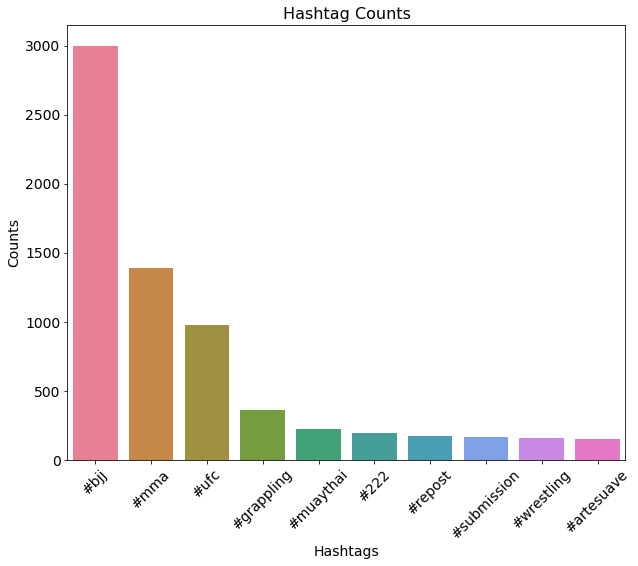

In [527]:
hashtags = []
for hs in df_u_tweets["processed_hashtags"]: # Each entry may contain multiple hashtags. Split.
    if hs != '':
        hashtags += hs

tags = pd.DataFrame(hashtags)
tags_cts = tags[0].value_counts().iloc[0:10]
tags_cts.index = '#' + tags_cts.index

plt.figure(figsize = (10,8))
sns.barplot(x=tags_cts.index, y=tags_cts, palette= sns.color_palette("husl", 10)) #, color = "steelblue")
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Hashtags', fontsize =14)
plt.ylabel('Counts', fontsize =14)
plt.title('Hashtag Counts', fontsize = 16)


In [528]:
# Get all document texts and their corresponding IDs.
#docs = []['text']
#doc_ids = []['id']
df_u_tweets.head(10)


,_id,dt,favorites,geo,hashtags,id,mentions,permalink,retweets,text,user,processed,processed_hashtags
0,5a9e18adc6b5b95b8bd66e43,2017-11-26 14:38:13,0,,,934793418630410241,,https://twitter.com/flashfights4u/status/934793418630410241,0,I’m sorry for your loss.,flashfights4u,"[sorry, loss]",[]
1,5a9e18adc6b5b95b8bd66e45,2017-11-20 05:40:08,0,,,932483681008185349,@gmail,https://twitter.com/flashfights4u/status/932483681008185349,0,We’re currently looking for people willing offer free content for beta test. NRotationtv@gmail.c...,flashfights4u,"[currently, looking, people, willing, offer, free, content, beta, test, com]",[]
2,5a9e18adc6b5b95b8bd66e4a,2017-11-18 23:44:47,0,,,932031863513866241,,https://twitter.com/flashfights4u/status/932031863513866241,0,Do you still attend ?,flashfights4u,"[still, attend]",[]
3,5a9e18adc6b5b95b8bd66e4b,2017-11-04 22:55:26,1,,,926946016888262664,,https://twitter.com/flashfights4u/status/926946016888262664,0,My nephew joined in..pic.twitter.com/Vnic3Q1k9T,flashfights4u,[joined],[]
4,5a9e18adc6b5b95b8bd66e4c,2017-11-04 22:54:27,0,,,926945769374052352,,https://twitter.com/flashfights4u/status/926945769374052352,0,Thank you so muchhttp://savageinstinctsapparel.com/?afmc=Gordon&utm_campaign=Gordon&utm_source=l...,flashfights4u,[thank],[]
5,5a9e18adc6b5b95b8bd66e51,2017-10-02 05:29:28,0,,,914723990077411328,,https://twitter.com/flashfights4u/status/914723990077411328,1,A larger brain doesn't mean more storage. Look at hard drives on computers today. From Megabytes...,flashfights4u,"[brain, mean, look, hard, drive, computer, today]",[]
6,5a9e18adc6b5b95b8bd66e52,2017-01-07 04:40:56,2,,,817591828669145093,@Thaoriginalgata @UrbanDryfter,https://twitter.com/flashfights4u/status/817591828669145093,4,Reasons to have a mansion - So rappers can rent out my place to make music videos. @Thaoriginalg...,flashfights4u,"[reason, place, make, music]",[]
7,5a9e18adc6b5b95b8bd66e53,2017-01-07 03:35:22,1,,,817575326721130496,,https://twitter.com/flashfights4u/status/817575326721130496,0,setting up shop in the texas area. How have you been?,flashfights4u,"[setting, shop, texas, area]",[]
8,5a9e18adc6b5b95b8bd66e54,2017-01-07 03:32:37,1,,,817574635848003585,,https://twitter.com/flashfights4u/status/817574635848003585,1,"http://paypal.me/scorchedearth Found an excellent location in town, Any support is appreciated.",flashfights4u,"[found, excellent, location, town, support]",[]
9,5a9e18adc6b5b95b8bd66e55,2016-11-09 20:44:14,1,,#ufc205,796453366826209280,@microphonephoen,https://twitter.com/flashfights4u/status/796453366826209280,1,So @microphonephoen doesn't get a spot for #ufc205?!?!?! She's been there since the beginning!!!!!,flashfights4u,"[get, spot, since, beginning]","[ufc, 205]"


## Author-Topic


In [11]:
# Get all author names and their corresponding document IDs.
author2doc = dict()
i = 0

for index, row in df_u_tweets.iterrows():
    #print(index, row[0])    
    author_name = row['user']
    #print(author_name)
    if not author2doc.get(author_name):
        author2doc[author_name] = []
        i += 1
        
    author2doc[author_name].extend([id for id in df_u_tweets.query('user==@author_name')['id']])
        
# # Use an integer ID in author2doc, instead of the IDs provided in the NIPS dataset.
# # Mapping from ID of document in NIPS datast, to an integer ID.
doc_id_dict = dict(zip(df_u_tweets['id'], range(len(df_u_tweets))))
# # Replace NIPS IDs by integer IDs.
for a, a_doc_ids in author2doc.items():
    for i, doc_id in enumerate(a_doc_ids):
        author2doc[a][i] = doc_id_dict[doc_id]

In [12]:
doc_ids = df_u_tweets['id']
docs = df_u_tweets['processed'].tolist()

In [13]:
# Compute bigrams.
from gensim.models import Phrases
bigram = Phrases(docs, min_count=50)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

/home/louis/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [17]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.

from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

max_freq = 0.5
min_wordcount = 20
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

_ = dictionary[0]  

In [18]:
dictionary.id2token[0]

'loss'

In [778]:
dictionary.token2id['bjj']

707

In [20]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

Let's inspect the dimensionality of our data.

In [21]:
corpus[3]

[]

In [22]:
d= 2 
corpus[d]
len(corpus)

36775

In [1653]:
len(model.top_topics(corpus))

x =[]
for i in range(49):
    x.append(sum(t[1] for t in model.top_topics(corpus, topn=i)))
    print(x)

/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/louis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan]
[nan, nan]
[nan, nan, -323.65204442616096]
[nan, nan, -323.65204442616096, -394.8676757980405]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.4589170631702]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.458

[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.4589170631702, -615.0476019182968, -631.0728570480542, -644.5058531643527, -660.1583131779818, -671.6788134576683, -682.5617169339193, -694.4395730018964, -709.3626470067599, -715.8709375797546, -721.9417214184775, -724.7135568807923, -732.1068388967461, -739.6203465758647, -745.2655289635882, -752.203268061977, -756.4278646215341, -761.3935227214882, -768.9191490527423, -776.0810679493212, -779.8810933819062, -781.727746605591]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.4589170631702, -615.0476019182968, -631.0728570480542, -644.5058531643527, -660.1583131779818, -671.6788134576683, -682.5617169339193, -694.4395730018964, -709.3626470067599, -715.8709375797546, -721.9417214184775, -724.7135568807923, -732.10683889674

[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.4589170631702, -615.0476019182968, -631.0728570480542, -644.5058531643527, -660.1583131779818, -671.6788134576683, -682.5617169339193, -694.4395730018964, -709.3626470067599, -715.8709375797546, -721.9417214184775, -724.7135568807923, -732.1068388967461, -739.6203465758647, -745.2655289635882, -752.203268061977, -756.4278646215341, -761.3935227214882, -768.9191490527423, -776.0810679493212, -779.8810933819062, -781.727746605591, -785.2034479626266, -788.6981189031701, -792.010747655914, -793.879644067593, -797.4821140663889, -801.1227685257843, -802.8155739111297, -805.0877041472075, -808.0722649907717, -811.6198640870072, -814.0087275132695, -815.2218281251124]
[nan, nan, -323.65204442616096, -394.8676757980405, -503.37422756364424, -525.2449380678181, -542.4835569903843, -556.3031209098455, -569.6760740057092, -593.4589170631702

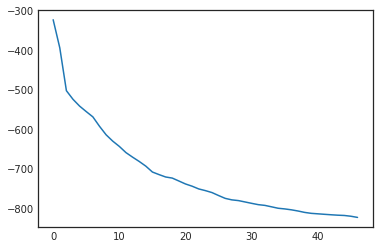

In [1682]:
plt.plot(x[2:])


In [1635]:
sum(t[1] for t in model.top_topics(corpus))

-724.7135568807923

In [16]:
%%time
model_list = []
start = time.time()
print(start)
for i in range(2):
    model = AuthorTopicModel(corpus=corpus, num_topics=100, id2word=dictionary.id2token, \
                    author2doc=author2doc, chunksize=2000, passes=300, gamma_threshold=1e-10, \
                    eval_every=0, iterations=50, random_state=i)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list.append((model, tc))
    print(i, time.time()-start)

1520749303.0757127


NameError: name 'AuthorTopicModel' is not defined

In [1089]:
model, tc = max(model_list, key=lambda x: x[1])
print('Topic coherence: %.3e' %tc)
#-7.247e+02
#-2.974e+02

Topic coherence: -2.974e+02


In [1094]:
model_list

[(<gensim.models.atmodel.AuthorTopicModel at 0x7f732d83e4a8>,
  -304.61038317450374),
 (<gensim.models.atmodel.AuthorTopicModel at 0x7f732c467a90>,
  -297.39839026552295)]

In [1091]:
# Save model.
#model.save('/tmp/model.atmodel4')

In [28]:
# # Load model.
model = AuthorTopicModel.load('/tmp/model.atmodel2')

### AT LDA Analysis


In [1156]:
i=-1

In [1195]:
i=21


In [1117]:
i=-1

In [1196]:
i+=1
print(topic_labels[i])
print(i)
model.show_topic(i,30)
#3 mma
#4 grappling/dev
#5 learning from vids
#6 ma
#13 bjj
#14 striking
#15 studying tech

boxing
22


[('fighting', 0.26262113895059025),
 ('cagecraze', 0.10771866891899137),
 ('latest_cagecraze', 0.10771866891899137),
 ('colin', 0.08022809650156963),
 ('latest_colin', 0.07908273627214023),
 ('williams_daily', 0.07908273627214023),
 ('assam', 0.06547035104205938),
 ('event_held', 0.05961233271087475),
 ('xmas', 0.015044939382489339),
 ('jones', 0.014835353478551184),
 ('strikeforce', 0.008930486024104256),
 ('loser', 0.00864798330198327),
 ('etc', 0.001870362516446833),
 ('absolute', 0.0008625680318022364),
 ('sick', 5.360078137913835e-05),
 ('term', 5.36007813530026e-05),
 ('humble', 5.360078133642291e-05),
 ('canada', 5.360078125911007e-05),
 ('daily', 5.360078121840508e-05),
 ('united', 5.360078119842973e-05),
 ('mma_fighting', 5.360078119759989e-05),
 ('cm', 5.3600781196159134e-05),
 ('india', 5.360078118923731e-05),
 ('roy', 5.3600781178113775e-05),
 ('williams', 5.3600781176776804e-05),
 ('chat', 5.3600781174186727e-05),
 ('version', 5.36007811662836e-05),
 ('san', 5.360078115331

Below, we have given each topic a label based on what each topic seems to be about intuitively. 

In [ ]:
training_bjj  bjj_techniques bjj_class talk

In [32]:
## model4 lalbels
# 3 media?
# 10 
# 14 random_5?
# 16?
# 18?
# 19 spanish
# 23 sprots betting?

topic_labels = ['fight main event', 'random_1', 'mma results', 'media', 'western wrest', \
               'grappling technique videos', 'random_2', 'training_bjj', 'piracy sharing', \
                'random_3', 'wrestling', 'training_mma', 'twitter activity', \
                'bjj_techniques', 'random_5', 'random_6', 'karate~', \
                'bjj_class talk', 'random_6', 'spanish_pickup', 'ufc fighters', \
                'random_7', 'boxing', 'sports betting', 'bloodyElbow', #] #, \
                'random_8', 'random_9', 'bjj submissions', 'random_10',
                'bjj podcasts', 'random_11', 'competing/schedule',
                'random_12', 'random_13', 'mma news 2', 'random_14',
                'fighting events', 'random_15', 'female fighters?', 'ufc', \
                'watching bjj', 'random_16', 'random_17', 'muay thai', \
                'mma torrents', 'sharing content', 'random_18', 'random_19', \
                'technique videos?', 'random_20']
len(topic_labels)

50

In [31]:
model.show_topics(num_topics=1)

[(3,
  '0.675*"mma" + 0.062*"till" + 0.048*"vol" + 0.045*"fu" + 0.039*"kung" + 0.029*"une" + 0.023*"combat" + 0.014*"hayabusa" + 0.008*"rumble" + 0.008*"fc"')]

[('v', 0.3233007664897564),
 ('main', 0.18957861167671194),
 ('main_event', 0.1258184138445087),
 ('barao', 0.07713506607446508),
 ('despite', 0.05218946154208027),
 ('k', 0.03793271280955471),
 ('b', 0.03378171573883153),
 ('instagram', 0.023941770190801986),
 ('donald', 0.011669714597740109),
 ('facebook', 0.01050615140039462)]

### Top Words for topics

In [1221]:
topic[0]

2

In [1228]:
model.show_topic(idx)

[('ufc', 0.10815305603049252),
 ('fight', 0.0471798041762181),
 ('v', 0.02333147747937085),
 ('champ', 0.01981279891115809),
 ('fighter', 0.01759419463689333),
 ('mcgregor', 0.015098348980950079),
 ('title', 0.015009542130685725),
 ('white', 0.014977225527541469),
 ('cyborg', 0.014014697227658924),
 ('say', 0.012934473440854608)]

In [40]:
for i in ['bjj_techniques']:
    idx = topic_labels.index(i)
    print('TOPIC LABEL:',i )
    words = ''
    #print(idx)
    for word, prob in model.show_topic(idx,30)[0:40]:
        words += word + ' ' 
    print('Words: ' + words)
    print('')

TOPIC LABEL: bjj_techniques
Words: bjj guard belt gracie v sweep back choke side gi leg armbar control pa triangle garcia halfguard side_control closed eddie marcelo keenan counter world mendes defense scout guest kneebar butterfly 



39

In [ ]:
Label: ufc fighters
Words: new_post apkhttps woodley tyron tyron_woodley anjos antonio lawler machida contest 

Label: ufc news
Words: ufc fight fight_night night v mma weigh elbow bellator episode 
    
Label: ufc
Words: ufc fight v champ fighter mcgregor title white cyborg say 

In [39]:
for topic in model.show_topics(num_topics=3):
    print('Label: ' + topic_labels[topic[0]])
    words = ''
    for word, prob in model.show_topic(topic[0],20):
        words += word + ' '
    print('Words: ' + words)
    print()

Label: boxing
Words: fighting mayweather boxing event_held floyd floyd_mayweather malignaggi finale animal argument teacher policy method age easy build especially likely public mom 

Label: random_11
Words: sure news discus itunes entire introduction let nj assault excited great policy teacher easy build argument method age animal public 

Label: mma results
Words: joe rogan bit sketch round little final second um california analysis week part recent bring test new_post uk com third 



In [1243]:
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [1248]:
def repeat_to_length(string_to_expand, length):
    return (string_to_expand * (int(length/len(string_to_expand))+1))[:length]

In [1257]:
repeat_to_length('a', round(1*100))

'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'

['fight main event',
 'random_1',
 'humor',
 'mma_1',
 'grappling',
 'mma/technique videos',
 'random2',
 'martial arts',
 'random_3',
 'random_4',
 'fight promotion',
 'mma news',
 'sports',
 'bjj',
 'random_5',
 'random_6',
 'karate~',
 'bjj class',
 'random_6',
 'random_7',
 'ufc fighters',
 'ufc news',
 'boxing',
 'sports betting',
 'ufc party',
 'random_8',
 'random_9',
 'bjj techniques',
 'random_10',
 'bjj podcasts',
 'random_11',
 'competing/schedule',
 'random_12',
 'random_13',
 'mma news 2',
 'random_14',
 'fighting events',
 'random_15',
 'female fighters?',
 'ufc',
 'watching bjj',
 'random_16',
 'random_17',
 'muay thai',
 'mma torrents',
 'sharing content',
 'random_18',
 'random_19',
 'technique videos?',
 'random_20']

In [1274]:
for i in ['sports betting']:
    idx = topic_labels.index(i)
    print('TOPIC LABEL:',i )
    words = ''
    #print(idx)
    print(idx)
    for word, prob in model.show_topic(idx, 30):
        print(word)
       # print(repeat_to_length(word+ ' ', int(round(prob*1000))))
        words = words + repeat_to_length(word+ ' ', int(round(prob*1000)))
    
words

TOPIC LABEL: sports betting
23
result
day
live
getting
action
play
line
round
back
may
anti
fighting
card
put
u
adult
williams
chris
roll
come
dan
picture
stop
board
quote
audio
quick
name
chance
final


'result result result result result result result resultday day day day day day day day daylive live live live live livgetting getting getting action action actionplay play play plline line line lround round rounback back back bmay may may maanti anti antifighting fighcard card caput put putu u u u u uadult adultwilliams wichris chriroll roll come comedan dan picture stop stoboard boquote quaudio aquick qname nachance final f'

In [1278]:
import random

In [1409]:

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return partial(palette_color_func, palette=5) #"husl(0, 0%%, %d%%)" % random.randint(80, 100)


In [1345]:
set(df_u_tweets['user'])

{'10PCM',
 '10thpbeaumont',
 '13guerreiros',
 '347493863',
 '5DBJJ',
 '6PackLapadat',
 '767pro',
 'AbeVonDoom',
 'AhmadNajiullah',
 'AlbertMagno',
 'Alltop_MMA',
 'Andy_Main',
 'AppQuality_org',
 'ArmanMusovic',
 'ArtechokeMedia',
 'ArtesMarcialesB',
 'Artesuaveeu',
 'BACombatSambo',
 'BJJLegends',
 'BJJRevolutionBR',
 'BJJ_Nation',
 'BQuickJiuJitsu',
 'BaltimoreMMA',
 'BayJiuJitsu',
 'BenFromAlaska',
 'BermudaCorrigan',
 'BlackBlizzNerd',
 'BloodyElbow',
 'Boxing_City',
 'BrandonQuick',
 'CMATKDBJJ',
 'CNBCTradersFan',
 'CageCraze',
 'CageCult',
 'CaglarMMA',
 'Calam1tyJan3',
 'CharlieMMAFAN',
 'ChrisSavarese',
 'CodyWilliamsINC',
 'ColinPlusPlus',
 'CombatVideos',
 'CriticalJo',
 'DanielPuroresu',
 'DarkGiftCombat',
 'DarthRader86',
 'DavidBranchMMA',
 'DigiPenn',
 'DinoFuoco',
 'Dixon_____',
 'DjangoMMA',
 'DownProg_net',
 'Drobertson145',
 'Ech05M1ke',
 'EpicFightingMMA',
 'EricToral1975',
 'FLABJJ',
 'FUCKBOBBYDANNY',
 'FakeKarate',
 'FelicityLyman1',
 'FightersDirect',
 'Fighting

In [1361]:
X = df_u_tweets.query('user == "mmafanaticism"')['processed']
for i in len(X):
    i.join

['dana',
 'white',
 'stephan',
 'ufc',
 'hall',
 'fame',
 'based',
 'one',
 'level',
 'changing',
 'loss',
 'griffin',
 'dana_white']

In [1369]:
' '.join(X.iloc[0])

'dana white stephan ufc hall fame based one level changing loss griffin dana_white'

In [1387]:
X = df_u_tweets.query('user == "bjjnews"')['processed']

tmp_words = ''
for i in X:
    tmp_words = tmp_words + ' '.join(i) + ' '

In [1388]:
tmp_words

'bernardo faria bjj learn bjj watching andrew smith way escape side grapplearts podcast episode interview cody jitsu bjj time someone try bjj bloody elbow dern win bloody_elbow bjj scout frankie edgar study modified frankie_edgar kurt osiander move week scissor bjj revolution bjj x guard bjj coach human ask question attack back bjj bjj brick choke head arm triangle phuket top team submissiongrappling technique escape option back grappling central episode robert drysdale return bjj hip hop style feature bjj bjj hero interview top bjj business man body lock mma mackenzie dern make long ufc debut ufc become motivation bjj bjj hero grappling central episode dirty white belt podcast x men revolution bjj single leg x guard x guard bjj brick bjj beast hardy easiest bjj triangle setup grapplearts step training new academy sit drill bjj flow bjj hero patrick build training environment mma fighting elains something prove ufc fox mma_fighting ufc_fox grapplearts bjj breathing trick bottom getting

In [1403]:
wordcloud.recolor(color_func=grey_color_func)

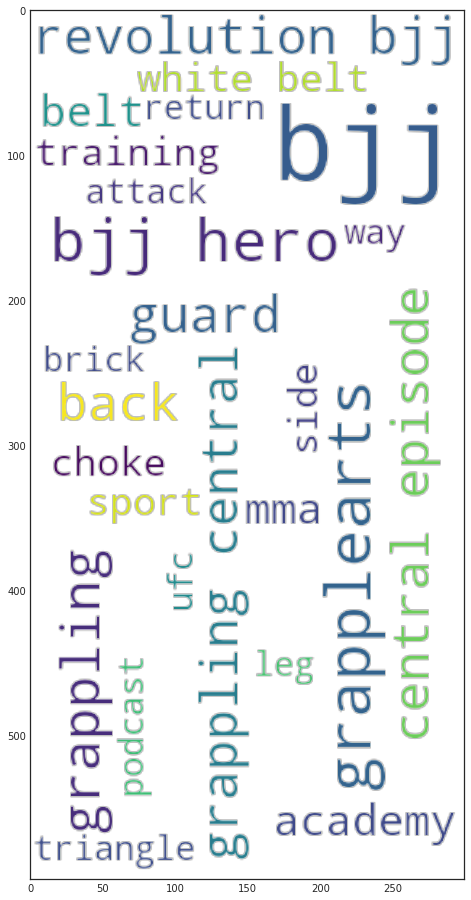

In [1413]:
words = tmp_words
#wordcloud = WordCloud(width=1000, height=500, regexp=r"\w[\w' ]+").generate("+".join(my_list))
#TOPIC_INDEX = 0
#samp_topic = df_du_tweets.loc[kmeans.predict(nmf_vecs) == TOPIC_INDEX]
#prev = samp_topic[[ 'text']]
#print(prev)
color_func = grey_color_func
wordcloud = WordCloud(width=300, height=600, background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=25).generate(text = words)
#print(prev.head(15))
#plt.axis("off")
#plt.savefig("terms1")
#print(prev.shape)

sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True'}):
    fig = plt.figure(figsize=(8,16))
    fig.patch.set_alpha(0.0)
    plt.figure(figsize = (8,16))
    plt.imshow(wordcloud, interpolation='bilinear') #.recolor(color_func=grey_color_func)
    
    plt.savefig('cloud2' +'.png', transparent=True)

            
    plt.show()
    #plt.close()

#print(TOPIC_INDEX)


# sns.set_style("whitegrid")
#     with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):
#         fig = plt.figure(figsize=(12,6))
#         fig.patch.set_alpha(0.5)
#         df_at = pd.DataFrame([(topic_labels[topic[0]], topic[1]) for topic in model[author_name]], columns = ['Topics', 'Dist'])
#         df_at.sort_values('Dist', ascending =False)

#         sns_plot = sns.barplot(df_at['Topics'][:(n_topic)], df_at['Dist'][:(n_topic)], \
#                     palette= sns.color_palette("husl", 10), ci=None)
#         plt.title("Twitter Profile: " + author_name, fontsize = 15 )
#         plt.ylabel('Density', fontsize = 16)
#         plt.xlabel('Topic', fontsize = 16)
#         plt.xticks(rotation=45, fontsize = 12)

#         if save != '':
#             fig = sns_plot.get_figure()
#             fig.savefig(save +'.png', transparent=True)
    

In [706]:
model.author2id

{'10PCM': 0,
 '10thpbeaumont': 1,
 '13guerreiros': 2,
 '347493863': 3,
 '5DBJJ': 4,
 '6PackLapadat': 5,
 '767pro': 6,
 'AbeVonDoom': 7,
 'AhmadNajiullah': 8,
 'AlbertMagno': 9,
 'Alltop_MMA': 10,
 'Andy_Main': 11,
 'AppQuality_org': 12,
 'ArmanMusovic': 13,
 'ArtechokeMedia': 14,
 'ArtesMarcialesB': 15,
 'Artesuaveeu': 16,
 'BACombatSambo': 17,
 'BJJLegends': 18,
 'BJJRevolutionBR': 19,
 'BJJ_Nation': 20,
 'BQuickJiuJitsu': 21,
 'BaltimoreMMA': 22,
 'BayJiuJitsu': 23,
 'BenFromAlaska': 24,
 'BermudaCorrigan': 25,
 'BlackBlizzNerd': 26,
 'BloodyElbow': 27,
 'Boxing_City': 28,
 'BrandonQuick': 29,
 'CMATKDBJJ': 30,
 'CNBCTradersFan': 31,
 'CageCraze': 32,
 'CageCult': 33,
 'CaglarMMA': 34,
 'Calam1tyJan3': 35,
 'CharlieMMAFAN': 36,
 'ChrisSavarese': 37,
 'CodyWilliamsINC': 38,
 'ColinPlusPlus': 39,
 'CombatVideos': 40,
 'CriticalJo': 41,
 'DanielPuroresu': 42,
 'DarkGiftCombat': 43,
 'DarthRader86': 44,
 'DavidBranchMMA': 45,
 'DigiPenn': 46,
 'DinoFuoco': 47,
 'Dixon_____': 48,
 'Django

In [707]:
model['mmarecruiter']

[(5, 0.030485613669182628),
 (7, 0.01316516317205606),
 (10, 0.03936985795635847),
 (13, 0.14184836360730868),
 (14, 0.017986147340183115),
 (18, 0.014134735133628493),
 (19, 0.04297007175519233),
 (21, 0.13812257515701534),
 (23, 0.03149732167770954),
 (29, 0.06804207849355816),
 (36, 0.015600221427521878),
 (37, 0.012393058112004345),
 (39, 0.32445554680288263),
 (43, 0.029880019110986637),
 (44, 0.018575126389296488),
 (48, 0.04028125879109017)]

In [708]:
model.show_topic(22)

[('fighting', 0.4194332772430499),
 ('mayweather', 0.1548808465378067),
 ('boxing', 0.12045918627411645),
 ('event_held', 0.08108281268224385),
 ('floyd', 0.06571275197422405),
 ('floyd_mayweather', 0.058027719009426916),
 ('malignaggi', 0.02170560870074657),
 ('finale', 0.004810710512949944),
 ('teacher', 3.646944080228811e-05),
 ('public', 3.646944080228811e-05)]

### Topics breakdown for a specified author

In [712]:
from pprint import pprint

def show_author(name):
    print('\n%s' % name)
 #   print('Docs:', model.author2doc[name])
    print('Topics:')
    pprint([(topic_labels[topic[0]], topic[1]) for topic in model[name]])
    
    
    

In [1314]:
show_author('mmarecruiter')


mmarecruiter
Topics:
[('grappling technique videos', 0.030485613669182628),
 ('training_bjj', 0.01316516317205606),
 ('pro wrestling', 0.03936985795635847),
 ('bjj_techniques', 0.14184836360730868),
 ('random_5', 0.017986147340183115),
 ('random_6', 0.014134735133628493),
 ('spanish_pickup', 0.04297007175519233),
 ('random_7', 0.13812257515701534),
 ('sports betting', 0.03149732167770954),
 ('bjj podcasts', 0.06804207849355816),
 ('fighting events', 0.015600221427521878),
 ('random_15', 0.012393058112004345),
 ('ufc', 0.32445554680288263),
 ('muay thai', 0.029880019110986637),
 ('mma torrents', 0.018575126389296488),
 ('technique videos?', 0.04028125879109017)]


In [1319]:
show_author('bjjnews')


bjjnews
Topics:
[('ufc', 0.01969056134965893),
 ('grappling technique videos', 0.05025745533920044),
 ('training_bjj', 0.09667739999541292),
 ('wrestling', 0.05830593230303908),
 ('bjj_techniques', 0.28080784435567835),
 ('random_5', 0.041778595656823396),
 ('random_6', 0.01870693213685297),
 ('bjj_class talk', 0.06483349160574807),
 ('random_6', 0.07892333260233192),
 ('spanish_pickup', 0.032039924673942115),
 ('random_7', 0.05154162052832832),
 ('bjj podcasts', 0.04632321471579979),
 ('random_15', 0.017240057163623344),
 ('ufc', 0.0159768615700401),
 ('muay thai', 0.015112176092156027),
 ('technique videos?', 0.05990594599350582),
 ('random_20', 0.03120161302111445)]


In [718]:
show_author('10thpbeaumont')


10thpbeaumont
Topics:
[('mma/technique videos', 0.043826905273905856),
 ('martial arts', 0.031121629898846277),
 ('fight promotion', 0.0867912852740365),
 ('mma news', 0.23376596007973763),
 ('bjj', 0.0492998383176795),
 ('random_6', 0.016343775432195923),
 ('bjj class', 0.18074718063563763),
 ('bjj techniques', 0.011464381452082681),
 ('competing/schedule', 0.045325178439169236),
 ('random_12', 0.017207171667140805),
 ('ufc', 0.06275807882852258),
 ('muay thai', 0.012531100000808789),
 ('technique videos?', 0.10360784053733453),
 ('random_20', 0.09371215191524195)]


In [1099]:
# n_topic = 10
# author_id = 7

def author_barplot(author_name, n_topic = 10, save = ''):
    sns.set_style("whitegrid")
    with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):
        fig = plt.figure(figsize=(12,6))
        fig.patch.set_alpha(0.5)
        df_at = pd.DataFrame([(topic_labels[topic[0]], topic[1]) for topic in model[author_name]], columns = ['Topics', 'Dist'])
        df_at.sort_values('Dist', ascending =False)

        sns_plot = sns.barplot(df_at['Topics'][:(n_topic)], df_at['Dist'][:(n_topic)], \
                    palette= sns.color_palette("husl", 10), ci=None)
        plt.title("Twitter Profile: " + author_name, fontsize = 15 )
        plt.ylabel('Density', fontsize = 16)
        plt.xlabel('Topic', fontsize = 16)
        plt.xticks(rotation=45, fontsize = 12)

        if save != '':
            fig = sns_plot.get_figure()
            fig.savefig(save +'.png', transparent=True)
    

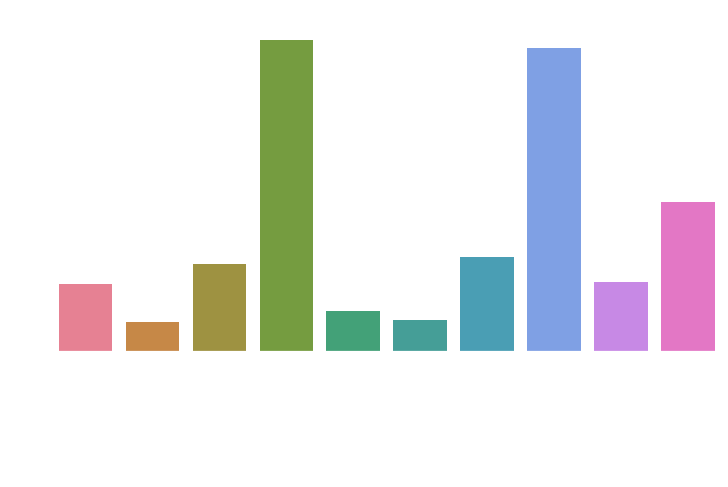

In [1086]:
author_barplot('mmarecruiter', save ='a_bplt_mmarecruiter')

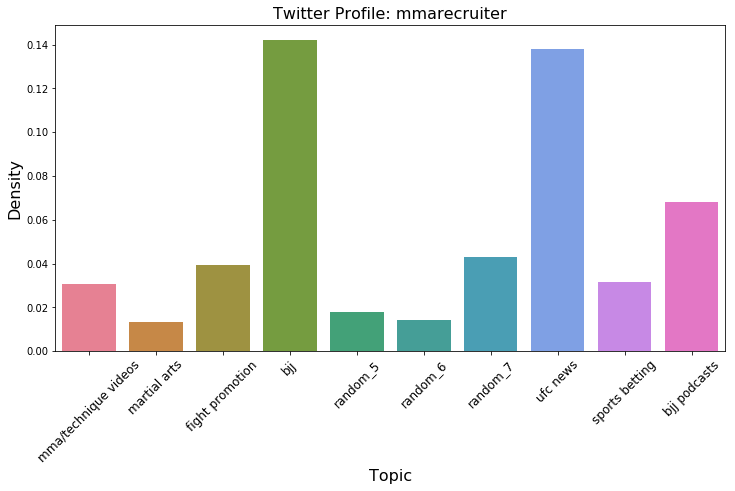

In [1043]:
author_barplot('mmarecruiter')

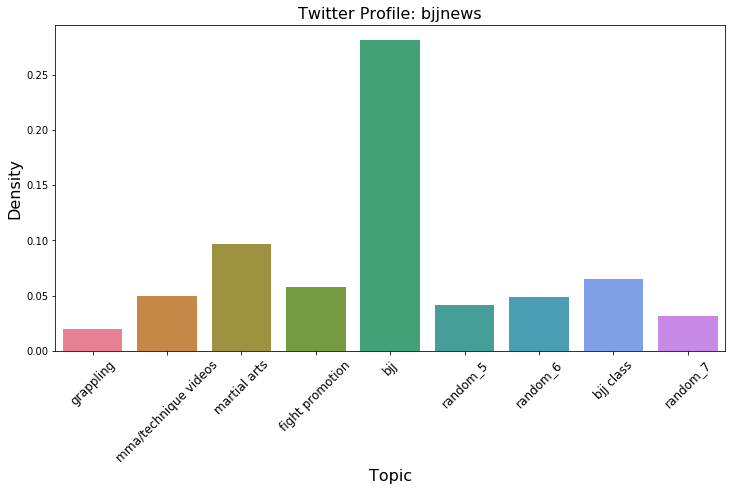

In [1044]:
author_barplot('bjjnews')

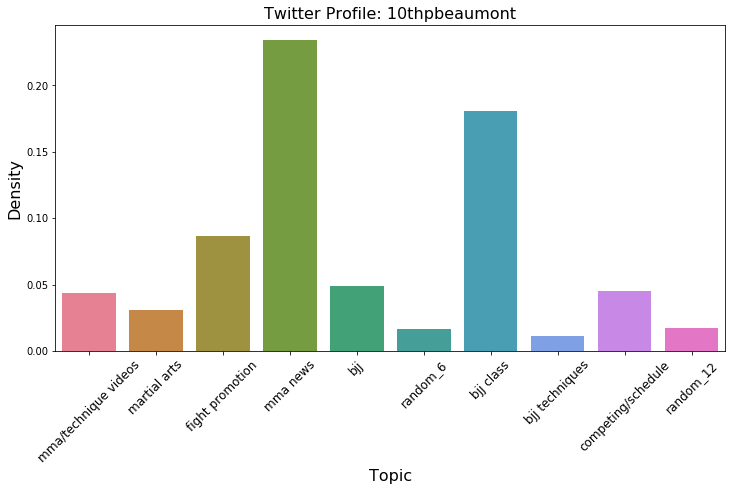

In [1045]:
author_barplot('10thpbeaumont')

In [992]:
df_at['Dist'].sum()

0.978807158595975

In [ ]:


hashtags = []
for hs in df_u_tweets["processed_hashtags"]: # Each entry may contain multiple hashtags. Split.
    if hs != '':
        hashtags += hs

tags = pd.DataFrame(hashtags)
tags_cts = tags[0].value_counts().iloc[0:10]
tags_cts.index = '#' + tags_cts.index

plt.figure(figsize = (10,8))
sns.barplot(x=tags_cts.index, y=tags_cts, palette= sns.color_palette("husl", 10)) #, color = "steelblue")
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Hashtags', fontsize =14)
plt.ylabel('Counts', fontsize =14)
plt.title('Hashtag Counts', fontsize = 16)


In [719]:
from gensim.models import atmodel
doc2author = atmodel.construct_doc2author(model.corpus, model.author2doc)

In [720]:
# Compute the per-word bound.
corpus_words = sum(cnt for document in model.corpus for _, cnt in document)



In [721]:
# Compute bound and divide by number of words.
perwordbound = model.bound([x for x in model.corpus if x != []], author2doc=model.author2doc, \
                           doc2author=model.doc2author) / corpus_words


In [1109]:
print(perwordbound)
##0.2676543256036854
#-0.37558275851297224

-0.37558275851297224


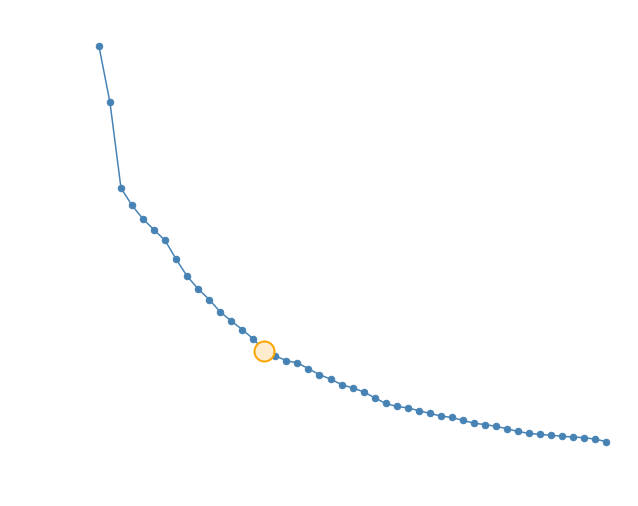

In [1699]:
#Elbow Plot

kclust_elbow = 17
clusters_rng = range(3,50)
sns.set_style("white")
with plt.rc_context({'nbagg.transparent':'True', 'axes.labelcolor': 'white', 'text.color':'white', 'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'white'}):

    plt.figure(figsize = (10,8))
    plt.plot(clusters_rng, x[2:], ".-", color = 'steelblue', markersize = 13)
    plt.plot(clusters_rng[17-2], x[17], marker='o', markersize=20, color = 'blanchedalmond',
             markeredgewidth=2, markeredgecolor='orange')#, markerfacecolor=None)
    plt.ylabel("uMASS", fontsize = 16)
    plt.xlabel("K Topics", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title("AT LDA elbow plot", fontsize = 18)
#    plt.show()


#    fig = plt_plot.get_figure()
    plt.savefig('direct_elbow_umass' +'.png', transparent=True)

#         plt.title("Twitter Profile: " + author_name, fontsize = 16 )
#         plt.ylabel('Density', fontsize = 16)
#         plt.xlabel('Topic', fontsize = 16)
#         plt.xticks(rotation=45, fontsize = 12)

        
        
        

In [421]:
%time top_topics = model.top_topics(model.corpus)

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 180 ms


In [724]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 0  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

CPU times: user 4.9 s, sys: 521 ms, total: 5.42 s
Wall time: 5.46 s


In [728]:
from gensim.similarities import MatrixSimilarity

index = MatrixSimilarity(model[list(model.id2author.values())])
author_name = 'mmarecruiter'
sims = index[model[author_name]]

In [732]:
from gensim import matutils
import pandas as pd


author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

def similarity(vec1, vec2):
    dist = matutils.hellinger(matutils.sparse2full(vec1, model.num_topics), \
                              matutils.sparse2full(vec2, model.num_topics))
    sim = 1.0 / (1.0 + dist)
    return sim

def get_sims(vec):
    sims = [similarity(vec, vec2) for vec2 in author_vecs]
    return sims

def get_table(name, top_n=10, smallest_author=1):

    sims = get_sims(model.get_author_topics(name))
    table = []
    for elem in enumerate(sims):
        author_name = model.id2author[elem[0]]
        sim = elem[1]
        author_size = len(model.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))

    df = pd.DataFrame(table, columns=['Author', 'Score', 'Size'])
    df = df.sort_values('Score', ascending=False)[:top_n]
    
    return df

In [729]:
len(set(df_u_tweets['user']))

375

In [733]:
[model.get_author_topics('mmarecruiter')]

[[(5, 0.030485613669182628),
  (7, 0.01316516317205606),
  (10, 0.03936985795635847),
  (13, 0.14184836360730868),
  (14, 0.017986147340183115),
  (18, 0.014134735133628493),
  (19, 0.04297007175519233),
  (21, 0.13812257515701534),
  (23, 0.03149732167770954),
  (29, 0.06804207849355816),
  (36, 0.015600221427521878),
  (37, 0.012393058112004345),
  (39, 0.32445554680288263),
  (43, 0.029880019110986637),
  (44, 0.018575126389296488),
  (48, 0.04028125879109017)]]

In [1315]:
get_table('mmarecruiter')

,Author,Score,Size
317,mmarecruiter,1.000000,10000
236,bjjleeds,0.694993,9801
117,MMAMELEE,0.689724,10000
371,xsmma,0.689070,10000
154,PITBOY,0.680144,10000
126,MMA_Norway_,0.676531,10000
254,damonkawai,0.672604,10000
295,keithdavone,0.672497,9216
199,TheNohoHobo,0.671800,7744
250,crazyjamescaird,0.670052,10000


As before, we can specify the minimum author size.

In [1320]:
get_table('bjjnews', smallest_author=3)

,Author,Score,Size
237,bjjnews,1.000000,10000
20,BJJ_Nation,0.746927,10000
236,bjjleeds,0.739707,9801
168,RollReviewBJJ,0.730638,2304
284,hudsonvalleybjj,0.729940,9604
233,bjj_empire,0.728578,9409
218,Zenbeijudoslc,0.722632,7225
193,TheBJJBot,0.714531,8100
18,BJJLegends,0.713170,9025
199,TheNohoHobo,0.710675,7744


get_table('bjjnews', smallest_author=3)

In [796]:
model.get_term_topics([707])

[(7, array([0.03482895])),
 (11, array([0.03018604])),
 (13, array([0.25684978])),
 (17, array([0.01964413]))]

In [812]:
td

{7: 0.03482895050193157,
 11: 0.030186044917175487,
 13: 0.25684978201398573,
 17: 0.019644129511627254}

In [800]:
ud

{5: 0.030485613669182628,
 7: 0.01316516317205606,
 10: 0.03936985795635847,
 13: 0.14184836360730868,
 14: 0.017986147340183115,
 18: 0.014134735133628493,
 19: 0.04297007175519233,
 21: 0.13812257515701534,
 23: 0.03149732167770954,
 29: 0.06804207849355816,
 36: 0.015600221427521878,
 37: 0.012393058112004345,
 39: 0.32445554680288263,
 43: 0.029880019110986637,
 44: 0.018575126389296488,
 48: 0.04028125879109017}

In [1455]:
get_author_pop_tops('mmarecruiter').iloc[0,0]

'ufc'

In [1600]:
model.get_term_topics(dictionary.token2id['bjj'])

[(7, 0.03482895050193157),
 (11, 0.030186044917175487),
 (13, 0.25684978201398573),
 (17, 0.019644129511627254)]

In [1597]:
from collections import Counter

def author_text_dist(model, author, text, most_popular=False):
        
    processed_tweet = process_tweet_text(text, clean = True)
    ud = dict(model[author])

    word_topic_counter = Counter()
    
    word_count = 0
    for i in processed_tweet:
        
        try:
            word_id = dictionary.token2id[i]
            td = dict(model.get_term_topics(word_id))
            word_dist = [[k,td[k]] for k in td if k in ud.keys()] 
            sum_word_dist = sum(wd[1] for wd in word_dist)
            curr_word_topic = Counter(dict([[k[0], k[1]/sum_word_dist]for k in word_dist]))
            word_topic_counter += curr_word_topic
            #print(curr_word_topic)
            if word_dist: 
                word_count += 1                
        except:
            pass
        
    final_word_topic_dist = dict(word_topic_counter)
    final_word_topic_dist.update((key, val/word_count) for key, val in final_word_topic_dist.items())  
    
    print(final_word_topic_dist)
    if most_popular:
        if text == "" or len(final_word_topic_dist) == 0:
            print('!:' , get_author_pop_tops(author).iloc[0,:])
            return topic_labels.index(get_author_pop_tops(author).iloc[0,0])
        else:
            return max(final_word_topic_dist, key=final_word_topic_dist.get)
    else:
        return final_word_topic_dist

test_dood = 'bjjnews'
test_string = "japan seminar sambo mma"
test = author_text_dist(model, test_dood, test_string, True)
print(test)
print("Example Author:", test_dood)
print("Test string: ", test_string)
print("Topic Label: ", topic_labels[test])
#
#bjj is guard playing and stuff. choke boom
#word_dist

#"SVD is cooler than PCA"

{48: 0.45440818287792534, 4: 0.3230250522861187, 7: 0.09820762226100584, 21: 0.12435914257495005}
48
Example Author: bjjnews
Test string:  japan seminar sambo mma
Topic Label:  technique videos?


In [1595]:
topic_labels[48]

'technique videos?'

In [1524]:
get_author_pop_tops('mmarecruiter').iloc[0,0]

'ufc'

In [1492]:
get_author_pop_tops('mmarecruiter').iloc[0,:].name

12

In [1632]:
1/6 * .33 

0.055

In [ ]:
def author_topic_highest_scoring():
    
    


In [1630]:
125/380

0.32894736842105265

In [1629]:
# hereee
bjj_labels = ['training_bjj',  'bjj_techniques', 'bjj_class talk']
i = 'mmarecruiter'
k=0
j = 0
for i in set(df_u_tweets['user']):
    j=j+1
#    print(j)

    pdg = get_author_pop_tops(i) 
    k += sum(pdg.rename({0:'label',1:'prob'}, axis = 1)[0:3]['label'].isin(bjj_labels))
    
print(k)
    
    
#.query("0 == 'bjj_techniques'")



125


In [1446]:
# hereee
def get_author_pop_tops(author):

    return pd.DataFrame([(topic_labels[topic[0]], topic[1]) for topic in model[author]]).sort_values(1, ascending=False)

In [ ]:
model.show_topics(num_topics=3)
[(topic_labels[topic[0]], topic[1]) for topic in model[name]]

In [763]:
model.show_topic(4,10)

[('wrestling', 0.27889931289110315),
 ('bottom', 0.05670668626261614),
 ('mma', 0.054538433278827236),
 ('weapon', 0.04607926308017692),
 ('near', 0.04519647577915593),
 ('usacw', 0.045067977731655245),
 ('trip', 0.04358731219887393),
 ('pm', 0.03791196347498048),
 ('sign', 0.03619181907924671),
 ('catch', 0.03324065244205337)]

In [739]:
author_vecs[0:4]

[[(4, 0.011284290797998241),
  (7, 0.028526727434406825),
  (9, 0.01072770717764496),
  (11, 0.23349728920182267),
  (15, 0.0166637480760137),
  (17, 0.17708803828143774),
  (18, 0.04155597523260257),
  (19, 0.09240735965919229),
  (23, 0.05095028730714621),
  (29, 0.08290330376371369),
  (31, 0.04808591323951523),
  (32, 0.02725301251197179),
  (35, 0.02584548946479575),
  (37, 0.044243087894156756),
  (48, 0.051948197420572426),
  (49, 0.01962523650735607)],
 [(5, 0.043826905273905856),
  (7, 0.031121629898846277),
  (10, 0.0867912852740365),
  (11, 0.23376596007973763),
  (13, 0.0492998383176795),
  (15, 0.016343775432195923),
  (17, 0.18074718063563763),
  (27, 0.011464381452082681),
  (31, 0.045325178439169236),
  (32, 0.017207171667140805),
  (39, 0.06275807882852258),
  (43, 0.012531100000808789),
  (48, 0.10360784053733453),
  (49, 0.09371215191524195)],
 [(2, 0.011936999378179401),
  (5, 0.12161808985609507),
  (7, 0.034571768548380254),
  (14, 0.10172747977446499),
  (25, 0.3

In [1087]:
292/687

0.42503639010189226

In [ ]:
l

In [1693]:
clusters_rng

range(3, 50)